In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=faf6a56ba1e67262fcd7d0a64041e5e365cc468a20765d8afe6b1d48c8b71170
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
data_directory = '/content/drive/MyDrive/CBOE_DATA'
sampling_freqency = '1S'

In [12]:
import os
def get_files_name(directory,cboe=True):
    if cboe:
        file_names = [f.split('_')[2] for f in os.listdir(directory) if len(f.split('_'))>=3]
    else:
        file_names = [directory+'/'+f for f in os.listdir(directory) if f.split('.')[-1]=='csv']
    file_names.sort()
    return file_names
train_files_list = get_files_name('/content/drive/MyDrive/CBOE_DATA/EURUSD')[-50:-22]
test_files_list = get_files_name('/content/drive/MyDrive/CBOE_DATA/EURUSD')[-22:]

In [4]:
from pathlib import PosixPath
import pandas as pd
import itertools , os
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import datetime
import numpy as np
import zipfile
def load_orderbook(path,level,cboe = True):
    if cboe == True :
        column_names = [['Date']] \
                  + [[f'BP{i}' , f'BV{i}'] for i in range(1, 6)] \
                  + ['M'] \
                  + [[f'AP{i}' , f'AV{i}'] for i in range(1, 6)] \
                  + [['']]

        column_names=list(itertools.chain.from_iterable(column_names))
        df = None
        with zipfile.ZipFile(path, 'r') as z:
          for file in z.namelist():
              if file.endswith('.lob'):
                  with z.open(file) as f:
                      df = pd.read_csv(f,header=None,names=column_names).iloc[:, :-1].drop(columns=['M'])
        df = df.dropna(subset=[f'BV{level}',f'AV{level}'])
        df = df.drop(columns=[c for c in df.columns[1:] if int(c[-1:])>level])
        df = df.set_index('Date')
        df.index = pd.to_datetime(df.index)
    else:
        df = pd.read_csv(path)
        df['Gmt time'] = pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S.%f')
        # df['Local time'] = pd.to_datetime(df['Local time'].str[:-9],format='%d.%m.%Y %H:%M:%S.%f')
        df = df.rename(columns={'Ask':'AP1','Bid':'BP1','AskVolume':'AV1','BidVolume':'BV1'})
        df = df.set_index('Gmt time')
    # for c in [f'BV{i}' for i in range(1, level + 1)]:
    #     df[c] = df[c] / 10000000
    # for c in [f'AV{i}' for i in range(1, level + 1)]:
    #     df[c] = df[c] / 10000000
    return df

In [5]:
def merge_orderbook(date, directory, currencies_list , level = 5 , cboe = True):
    df = {}
    for c in currencies_list:
        if cboe:
            df[c] = load_orderbook(f'{directory}/{c}/tks_ny_{date}_{c}.zip',level,cboe)
        else:
            df[c] = load_orderbook(f'{directory}/{date}',level,cboe)

    start_time = max([df[c].index.min() for c in currencies_list])
    end_time   = min([df[c].index.max() for c in currencies_list])

    for c in currencies_list:
        # df[c].index = pd.to_datetime(df[c].index)
        df[c] = df[c].add_prefix(f'{c}_')

    final_df = df[currencies_list[0]]
    for c in currencies_list[1:]:
        final_df = pd.merge(final_df, df[c], left_index=True, right_index=True, how='outer')

    final_df = final_df.fillna(method='ffill').loc[start_time:end_time]

    return final_df

In [16]:
import numpy as np
# import pandas_ta as ta

def prepare_X_Y(dates_list, input_currencies ,target_currency , memory_horizon , forecast_horizon , cboe = True , only_market_price = False):
    X = []
    _target = []
    for date in dates_list:
        merged_df = merge_orderbook(date, data_directory ,list(set(input_currencies + [target_currency])) , 1 , cboe)
        merged_df = merged_df.resample(sampling_freqency).mean().fillna(method='ffill')
        target = merged_df[[target_currency+'_BP1', target_currency+'_AP1']]

        if only_market_price:
            _target.append(target)
            continue

        merged_df = merged_df[[c for c in merged_df.columns for in_curr in input_currencies if in_curr in c]]

        merged_df['OBI1'] =  (merged_df[f'{target_currency}_AV1'] -  merged_df[f'{target_currency}_BV1'])/(merged_df[f'{target_currency}_AV1'] +  merged_df[f'{target_currency}_BV1'])
        merged_df['OBI1_AVG'] = merged_df['OBI1'].rolling(forecast_horizon).mean()
        # merged_df['OBI2'] =  (merged_df[f'{target_currency}_AV2'] -  merged_df[f'{target_currency}_BV2'])/(merged_df[f'{target_currency}_AV2'] +  merged_df[f'{target_currency}_BV2'])
        # merged_df['OBI3'] =  (merged_df[f'{target_currency}_AV3'] -  merged_df[f'{target_currency}_BV3'])/(merged_df[f'{target_currency}_AV3'] +  merged_df[f'{target_currency}_BV3'])

        merged_df['mid_change'] = (merged_df[f'{target_currency}_AP1']+merged_df[f'{target_currency}_BP1'])/2

        merged_df['sma1'] = merged_df['mid_change'].rolling(forecast_horizon).mean()
        merged_df['diff_sma1'] = np.log(merged_df['mid_change']) - np.log(merged_df['sma1'])

        merged_df['sma2'] = merged_df['mid_change'].rolling(2*forecast_horizon).mean()
        merged_df['diff_sma2'] = np.log(merged_df['mid_change']) - np.log(merged_df['sma2'])

        merged_df['sma4'] = merged_df['mid_change'].rolling(4*forecast_horizon).mean()
        merged_df['diff_sma4'] = np.log(merged_df['mid_change']) - np.log(merged_df['sma4'])

        merged_df['sma8'] = merged_df['mid_change'].rolling(8*forecast_horizon).mean()
        merged_df['diff_sma8'] = np.log(merged_df['mid_change']) - np.log(merged_df['sma8'])

        merged_df['sma16'] = merged_df['mid_change'].rolling(16*forecast_horizon).mean()
        merged_df['diff_sma16'] = np.log(merged_df['mid_change']) - np.log(merged_df['sma16'])

        merged_df['sma1_sma2'] = np.log(merged_df['sma1']) - np.log(merged_df['sma2'])
        merged_df['sma2_sma4'] = np.log(merged_df['sma2']) - np.log(merged_df['sma4'])
        merged_df['sma4_sma8'] = np.log(merged_df['sma4']) - np.log(merged_df['sma8'])
        merged_df['sma8_sma16'] = np.log(merged_df['sma8']) - np.log(merged_df['sma16'])

        merged_df['channel16'] = (merged_df['mid_change'] - (merged_df['mid_change'].rolling(16*forecast_horizon).max() + merged_df['mid_change'].rolling(16*forecast_horizon).min())/2) / \
                    ((merged_df['mid_change'].rolling(16*forecast_horizon).max() - merged_df['mid_change'].rolling(16*forecast_horizon).min())/2)

        merged_df['channel16_shift'] = (merged_df['mid_change'] - (merged_df['mid_change'].rolling(16*forecast_horizon).max() + merged_df['mid_change'].rolling(16*forecast_horizon).min()).shift(forecast_horizon)/2) / \
                    ((merged_df['mid_change'].rolling(16*forecast_horizon).max() - merged_df['mid_change'].rolling(16*forecast_horizon).min()).shift(forecast_horizon)/2)

        merged_df['channel_std16'] = ((merged_df['mid_change'] - merged_df['sma16']) / merged_df['mid_change'].rolling(16*forecast_horizon).std()).clip(lower=-3, upper=3)

        merged_df['mid_change_1'] = np.log(merged_df['mid_change']).diff(forecast_horizon)

        merged_df.replace([np.inf, -np.inf], 0, inplace=True)

        merged_df = merged_df[['channel16','channel16_shift','channel_std16','mid_change_1','sma1_sma2','sma2_sma4',\
                               'sma4_sma8','sma8_sma16','OBI1_AVG','diff_sma1','diff_sma2','diff_sma4','diff_sma8','diff_sma16']].dropna()

        result_df = pd.DataFrame()
        for lag in range(memory_horizon):
            lagged_df = merged_df.shift(lag*forecast_horizon)
            lagged_df.columns = [f"{col}_lag{lag*forecast_horizon}" for col in merged_df.columns]
            result_df = pd.concat([result_df, lagged_df], axis=1)

        # price=(merged_df[f'{target_currency}_AP1']+merged_df[f'{target_currency}_AP1'])/2
        # volume=(merged_df[f'{target_currency}_AV1']+merged_df[f'{target_currency}_AV1'])/2
        # ohlov=price.resample('1s').ohlc()
        # ohlov['close']=ohlov['close'].fillna(method='ffill')
        # ohlov = ohlov.fillna(axis=1, method='backfill')
        # ohlov['volume']=volume.resample('1s').mean().fillna(method='ffill')
        # ohlov.dropna(inplace=True)

        # features =['RVGIs_14_4_lage_10','PVOh_12_26_9_lage_6','KURT_30_lage_0','PVOh_12_26_9_lage_0','PVT_lage_0','ADX_14_lage_10','VHF_28_lage_10','AD_lage_0','CMO_14_lage_0','SKEW_30_lage_0','EOM_14_100000000_lage_0','CFO_9_lage_0',
        # 'ABER_ATR_5_15_lage_0','PVO_12_26_9_lage_10','MASSI_9_25_lage_1','INERTIA_20_14_lage_10','KVOs_34_55_13_lage_0','PVOh_12_26_9_lage_10','NATR_14_lage_0',
        # 'NVI_1_lage_0','J_9_3_lage_0','BR_26_lage_0','KVO_34_55_13_lage_0','KURT_30_lage_10','AR_26_lage_10','SMIo_5_20_5_lage_0','PPOh_12_26_9_lage_10','EFI_13_lage_0','CMF_20_lage_0','PVO_12_26_9_lage_0',
        # 'SKEW_30_lage_10','ADOSC_3_10_lage_0','TRIXs_30_9_lage_10','CMF_20_lage_10','KVOs_34_55_13_lage_10','RVGI_14_4_lage_0','VHF_28_lage_0','PVOs_12_26_9_lage_10',
        # 'ADX_14_lage_0','CHOP_14_1_100_lage_0','PVI_1_lage_0','MASSI_9_25_lage_0','AR_26_lage_0','MASSI_9_25_lage_10','TOS_STDEVALL_LR_lage_0','RVI_14_lage_0']

        # ohlov.ta.strategy(ta.AllStrategy,lookahead=False)

        # result_df = pd.DataFrame()
        # for col in ohlov.columns:
        #   for lag in range(0,memory_horizon+1):
        #       if (col+'_lage_'+str(lag)) in features:
        #           result_df[col+'_lage_'+str(lag)]=ohlov[col].shift(lag)

        result_df = result_df.dropna()
        shifted_index = target.index - datetime.timedelta(seconds=forecast_horizon)
        result_df = result_df.loc[shifted_index[0]:shifted_index[-1]]
        shifted_index = result_df.index + datetime.timedelta(seconds=forecast_horizon)
        target_ = target.loc[shifted_index].mean(axis=1).to_numpy() - \
            target.loc[result_df.index].mean(axis=1).to_numpy()
        X.append(result_df)
        _target.append(target_)

    if only_market_price:
        return pd.concat(_target,axis=0)

    _target = np.concatenate(_target)
    X=pd.concat(X,axis=0)
    return X , _target

In [29]:
def model_batch_training(X_train,Y_train,threshold,batch_size=10000,initial_model=None):
    model = initial_model
    params = {
    'objective': 'multiclassova',  # Multi-class classification
    'metric': 'multi_logloss',  # Common metric for multi-class classification
    'num_class': 3,             # Number of classes
    'is_unbalance' : True,
    'boosting_type': 'gbdt',
    'num_leaves': 63,
    'learning_rate': 0.02,
    'feature_fraction': 1,
    'force_col_wise': True,
    'verbose' : -1
    }
    Y_train[np.abs(Y_train) < threshold] = 0
    Y_train = np.sign(Y_train) + 1
    if batch_size ==-1:
        lgb_train = lgb.Dataset(X_train,  label = Y_train)
        if model == None:
            model = lgb.train(params, lgb_train, num_boost_round=400)
        else:
            params['learning_rate']=0.003
            model = lgb.train(params, lgb_train, num_boost_round=25, init_model=model)
    else:
      for i in range(0, len(Y_train),batch_size):
          lgb_train = lgb.Dataset(X_train[i:i+batch_size],  label = Y_train[i:i+batch_size])

          if model == None:
              model = lgb.train(params, lgb_train, num_boost_round=400)
          else:
              params['learning_rate']=0.003
              model = lgb.train(params, lgb_train, num_boost_round=25, init_model=model)

    return model

In [9]:
from tqdm import tqdm

def pnl_confidence_sensivity_evaluate(model, features , market_price_data , trading_mode = 1):

    pnl = []
    for i in tqdm(range(0,90,3)):
        pnl.append(PlayBackMarket_backtest(model, features , market_price_data, i/100 , trading_mode)[-1])

    return  np.array(pnl)

In [ ]:
from sklearn import metrics

def evaluate_model(model, X_test_, Y_test_  ,confidence_level=0):

    prob_predictions = model.predict(X_test_)

    indices = np.where(np.max(prob_predictions, axis=1) >= confidence_level)[0]

    Y_pred = np.argmax(prob_predictions[indices], axis=1)

    true_direction_predictions = np.sum(Y_pred == (np.sign(Y_test_)+1)[indices])

    accuracy = true_direction_predictions / len(indices)

    print("Accuracy :",accuracy)

    confusion_matrix = metrics.confusion_matrix((np.sign(Y_test_))[indices], Y_pred-1)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [-1, 0 , 1])

    cm_display.plot()

    plt.show()

    # Y_pred -= 1

    # trades = Y_pred * Y_test_[indices]

    # trades = trades[trades!=0]

    # return  accuracy

In [28]:
from tqdm import tqdm
def PlayBackMarket_backtest(model, input_LOB_files , market_price_files , threshold, confidence_level=0, trading_mode=1 , print_result = False, initial_money=1000):
    #Mode 1 : Close position in any time prediction confidence come below confidence_level or pred_direction == 0
    #Mode 1 : DONT close opened position in pred_direction == 0
    #Mode 3 : Close position in pred_direction == 0

    market_price_files.sort()
    input_LOB_files.sort()
    position = 0
    position_contract = 1
    pnl=0
    equity_history = []
    indexs = []
    trades = []
    win_trades_cnt = 0
    trades_cnt = 0
    money = initial_money
    last_features = None
    last_target = None
    for _days in tqdm(range(0,len(input_LOB_files))):
        features , target   = prepare_X_Y(input_LOB_files[_days:_days+1], input_currencies, target_currency, memory_horizon, forecast_horizon ,cboe=True)
        #update model
        if _days>0:
            model = model_batch_training(last_features,last_target,threshold,-1,model)
        last_features = features
        last_target = target
        market_price_data = load_orderbook(market_price_files[_days],1,False).resample(sampling_freqency).first().fillna(method='ffill')
        market_price_data.index = market_price_data.index - pd.Timedelta(hours=5, minutes=0)

        start_time = max([features.index.min() , market_price_data.index.min()])
        end_time   = min([features.index.max() , market_price_data.index.max()])

        features = features.loc[start_time:end_time]
        market_price_data = market_price_data.loc[start_time:end_time]

        for i in range(0,len(features)-forecast_horizon,forecast_horizon):
            money = max(initial_money + pnl,0)
            equity_history.append(money)
            indexs.append(features.index[i])
            if money == 0 :
                break
            prob_predictions = model.predict(features.iloc[i:i+1])
            if np.max(prob_predictions, axis=1) < confidence_level:
                if trading_mode != 1:
                    predicted_direction = np.argmax(prob_predictions, axis=1)[0] - 1
                    if predicted_direction == 1 and  position<0:
                        pnl += -1 * position_contract * market_price_data['AP1'].iloc[i] - position
                        if -1 * position_contract * market_price_data['AP1'].iloc[i] - position > 0 :
                            win_trades_cnt+=1
                        trades.append({"time":features.index[i],"size":1,"price":market_price_data['AP1'].iloc[i]})
                        position = 0
                        # position_contract = 0
                    elif predicted_direction == -1 and  position>0:
                        pnl += position_contract * market_price_data['BP1'].iloc[i] - position
                        if position_contract * market_price_data['BP1'].iloc[i] - position > 0 :
                            win_trades_cnt+=1
                        trades.append({"time":features.index[i],"size":-1,"price":market_price_data['BP1'].iloc[i]})
                        position = 0
                        # position_contract = 0
                    elif predicted_direction == 0 and  position!=0 and trading_mode==3:
                        if position < 0 :
                            pnl += -1 * position_contract * market_price_data['AP1'].iloc[i] - position
                            if -1 * position_contract * market_price_data['AP1'].iloc[i] - position > 0 :
                                win_trades_cnt+=1
                            trades.append({"time":features.index[i],"size": 1,"price":market_price_data['AP1'].iloc[i]})
                        else :
                            pnl += position_contract * market_price_data['BP1'].iloc[i] - position
                            if position_contract * market_price_data['BP1'].iloc[i] - position > 0 :
                                win_trades_cnt+=1
                            trades.append({"time":features.index[i],"size": -1,"price":market_price_data['BP1'].iloc[i]})
                        # position_contract = 0
                        position = 0

                if position !=0 and trading_mode==1:
                    if position < 0 :
                        pnl += -1 * position_contract * market_price_data['AP1'].iloc[i] - position
                        if -1 * position_contract * market_price_data['AP1'].iloc[i] - position > 0 :
                            win_trades_cnt+=1
                        trades.append({"time":features.index[i],"size": 1,"price":market_price_data['AP1'].iloc[i]})
                    else:
                        pnl += position_contract * market_price_data['BP1'].iloc[i] - position
                        if position_contract * market_price_data['BP1'].iloc[i] - position > 0 :
                            win_trades_cnt+=1
                        trades.append({"time":features.index[i],"size": -1,"price":market_price_data['BP1'].iloc[i]})

                    # position_contract = 0
                    position = 0
            else:
                predicted_direction = np.argmax(prob_predictions, axis=1)[0] - 1
                if predicted_direction == 1 and  position<0:
                    trades_cnt+=1
                    pnl += -1 *position_contract * market_price_data['AP1'].iloc[i] - position
                    if -1 *position_contract * market_price_data['AP1'].iloc[i] - position > 0 :
                        win_trades_cnt+=1
                    # position_contract = money / market_price_data['BP1'].iloc[i]
                    position = 1 * position_contract * market_price_data['AP1'].iloc[i]
                    trades.append({"time":features.index[i],"size":2,"price":market_price_data['AP1'].iloc[i]})
                elif predicted_direction == -1 and  position>0:
                    trades_cnt+=1
                    pnl += position_contract * market_price_data['BP1'].iloc[i] - position
                    if position_contract * market_price_data['BP1'].iloc[i] - position > 0 :
                        win_trades_cnt+=1
                    # position_contract = money / market_price_data['BP1'].iloc[i]
                    position = -1 * position_contract * market_price_data['BP1'].iloc[i]
                    trades.append({"time":features.index[i],"size":-2,"price":market_price_data['BP1'].iloc[i]})
                elif predicted_direction == 0 and  position!=0 and trading_mode!=2:
                    if position < 0 :
                        pnl += -1 * position_contract * market_price_data['AP1'].iloc[i] - position
                        if -1 * position_contract * market_price_data['AP1'].iloc[i] - position > 0 :
                            win_trades_cnt+=1
                        trades.append({"time":features.index[i],"size": 1,"price":market_price_data['AP1'].iloc[i]})
                    else :
                        pnl += position_contract * market_price_data['BP1'].iloc[i] - position
                        if position_contract * market_price_data['BP1'].iloc[i] - position > 0 :
                            win_trades_cnt+=1
                        trades.append({"time":features.index[i],"size":-1,"price":market_price_data['BP1'].iloc[i]})
                    # position_contract = 0
                    position = 0
                elif predicted_direction != 0 and  position==0:
                    trades_cnt+=1
                    if predicted_direction == -1 :
                        # position_contract = money / market_price_data['BP1'].iloc[i]
                        position = -1 * position_contract * market_price_data['BP1'].iloc[i]
                        trades.append({"time":features.index[i],"size":-1,"price":market_price_data['BP1'].iloc[i]})
                    else :
                        # position_contract = money / market_price_data['BP1'].iloc[i]
                        position = 1 * position_contract * market_price_data['AP1'].iloc[i]
                        trades.append({"time":features.index[i],"size": 1,"price":market_price_data['AP1'].iloc[i]})
        if position !=0 :
            if position < 0 :
                pnl += -1 * position_contract * market_price_data['AP1'].iloc[-1] - position
                if -1 * position_contract * market_price_data['AP1'].iloc[-1] - position > 0 :
                    win_trades_cnt+=1
                trades.append({"time":features.index[i],"size": 1,"price":market_price_data['AP1'].iloc[i]})
            else :
                pnl += position_contract * market_price_data['BP1'].iloc[-1] - position
                if position_contract * market_price_data['BP1'].iloc[i] - position > 0 :
                    win_trades_cnt+=1
                trades.append({"time":features.index[i],"size":-1,"price":market_price_data['BP1'].iloc[i]})

            money = max(initial_money + pnl,0)
            equity_history.append(money)
            indexs.append(features.index[i])

    equity_history = pd.Series(equity_history, index=indexs)
    if print_result:
        print("Trades : ",trades_cnt)
        print("Win Rate[%] :",win_trades_cnt/trades_cnt*100)
        print("PnL : ",equity_history[-1])
        print("Return[%] :",(equity_history[-1]/equity_history[0]-1)*100)
        i = np.argmax(np.maximum.accumulate(equity_history) - equity_history) # end of the period
        if i!=0:
            j = np.argmax(equity_history[:i]) # start of period
            print("DrawDown[%] : ",(equity_history[i]/equity_history[j]-1)*100)
        else:
            j=0
            print("DrawDown[%] : 0")
        plt.plot(equity_history)
        plt.plot([equity_history.index[i], equity_history.index[j]], [equity_history.iloc[i], equity_history.iloc[j]], 'o', color='Red', markersize=10)
    return  equity_history , pd.DataFrame(trades)

In [11]:
input_currencies = ['EURUSD']
target_currency = 'EURUSD'
memory_horizon = 10  # 10 second snapshot LOB for feature
forecast_horizon = 5  # predict next 5 second

In [ ]:
# model = lgb.Booster(model_file='/content/drive/MyDrive/XAUUSD_GBMmodel-2023-11-23.txt')

In [ ]:
# model.save_model('/content/drive/MyDrive/XAUUSD_L3_GBMmodel-2023-11-23.txt')

In [17]:
X_train , Y_train = prepare_X_Y(train_files_list, input_currencies, target_currency, memory_horizon, forecast_horizon , cboe =True)

In [ ]:
X_test , Y_test  =  prepare_X_Y(test_files_list, input_currencies, target_currency, memory_horizon, forecast_horizon ,cboe=True)

In [23]:
threshold = Y_train.std()

In [22]:
model = model_batch_training(X_train , Y_train ,threshold , -1)

Accuracy : 0.44562288543785106


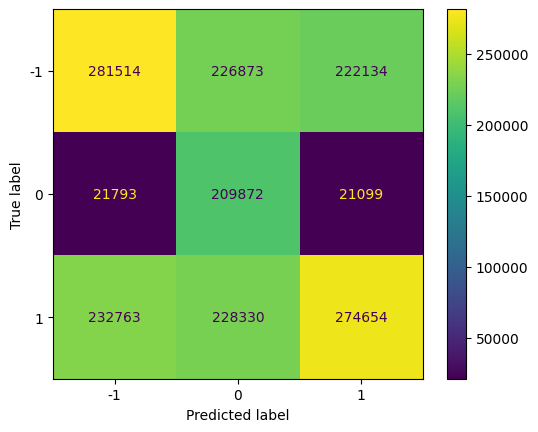

In [ ]:
evaluate_model(model , X_test , Y_test , confidence_level = 0.0)

100%|██████████| 1/1 [00:35<00:00, 35.12s/it]


Trades :  1349
Win Rate[%] : 21.423276501111935
PnL :  9.958360000000017
Return[%] : -0.416399999999828
DrawDown[%] :  -0.4165991668014901


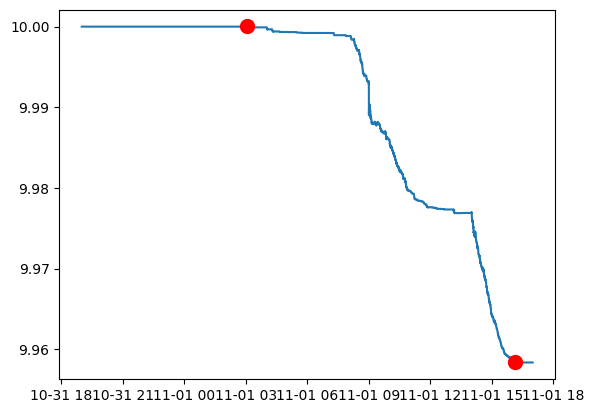

In [34]:
broker_price_files = get_files_name('/content/broker_price/EURUSD',False)
equity_history , trades = PlayBackMarket_backtest(model , test_files_list[:1], broker_price_files[:1] ,threshold , \
                                                  confidence_level = 0.7 , trading_mode = 1 , print_result = True , initial_money = 10)

<Axes: title={'center': 'LightGBM Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

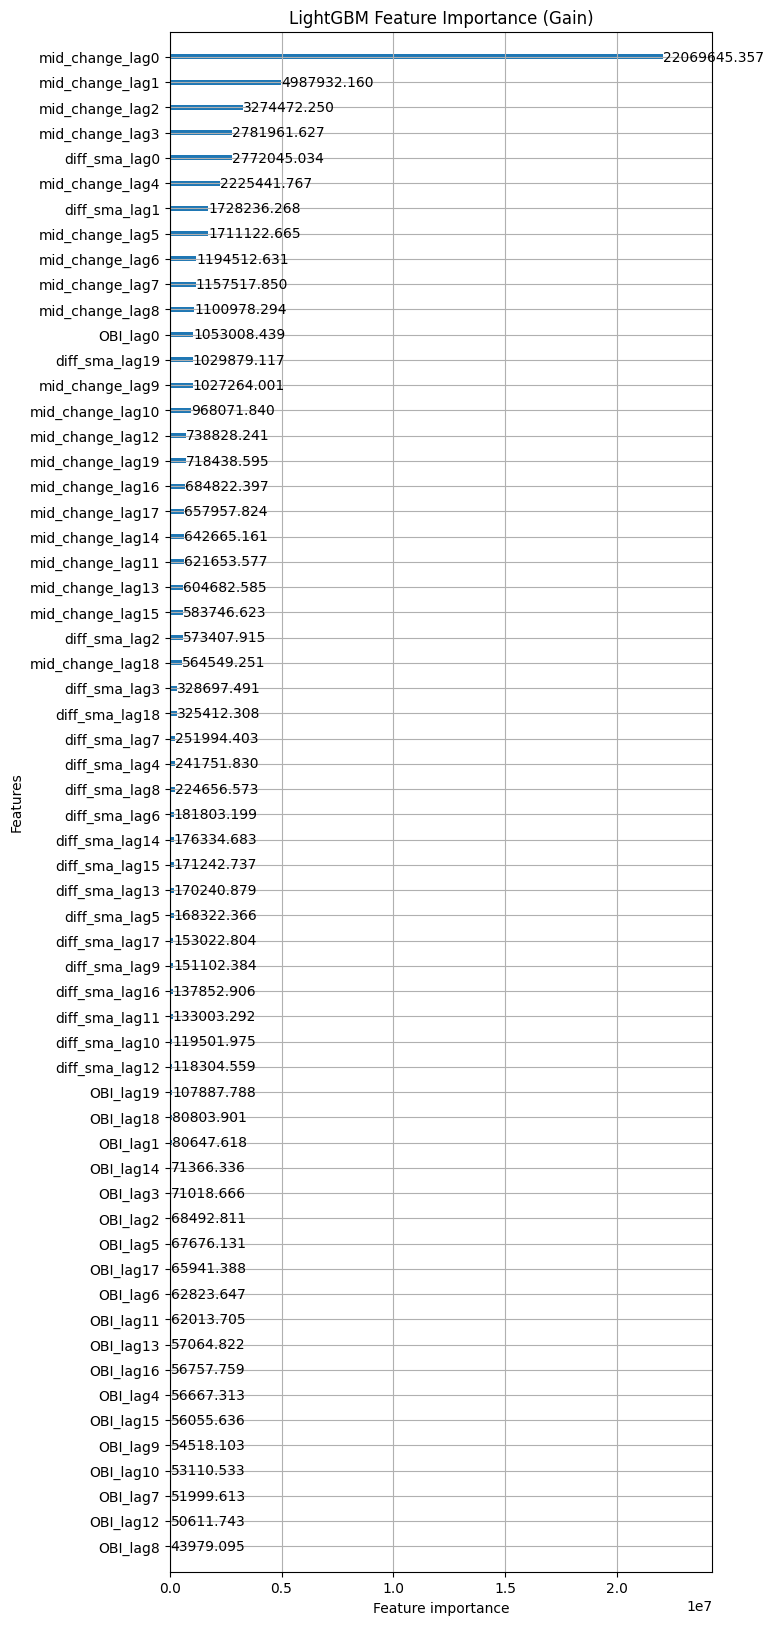

In [ ]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,20), title="LightGBM Feature Importance (Gain)")

<Axes: title={'center': 'LightGBM Feature Importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

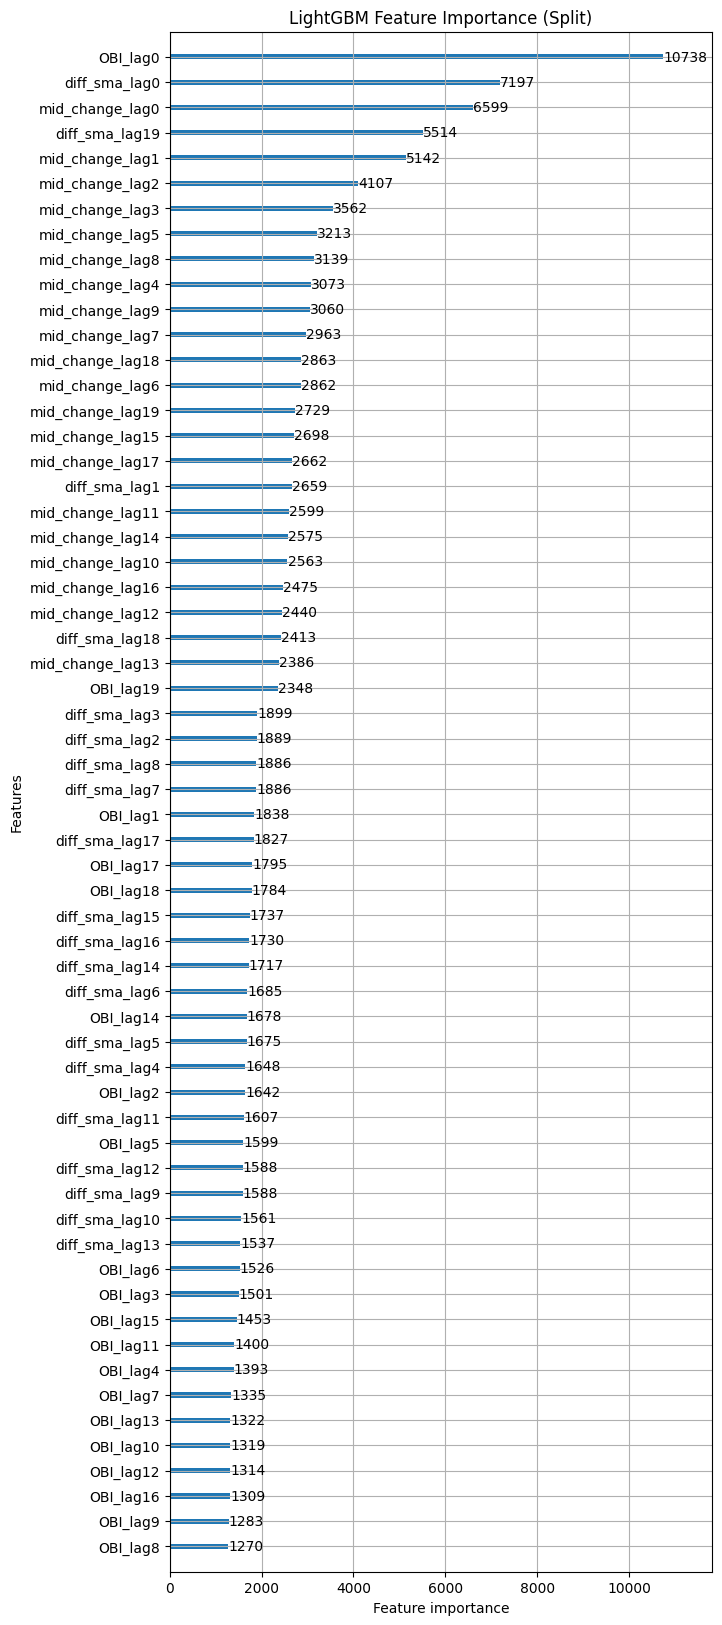

In [ ]:
lgb.plot_importance(model, importance_type="split", figsize=(7, 20), title="LightGBM Feature Importance (Split)")